filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename :  RGB
filename

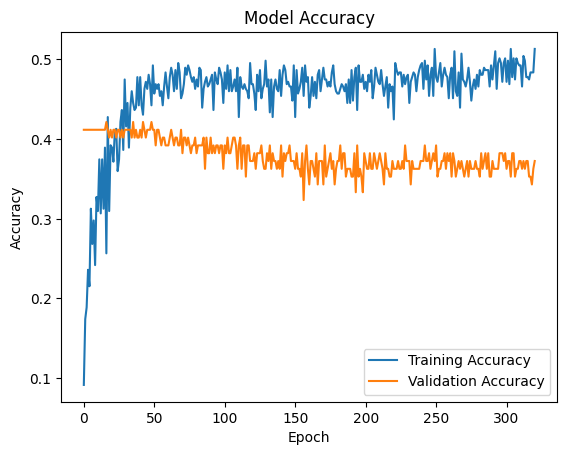

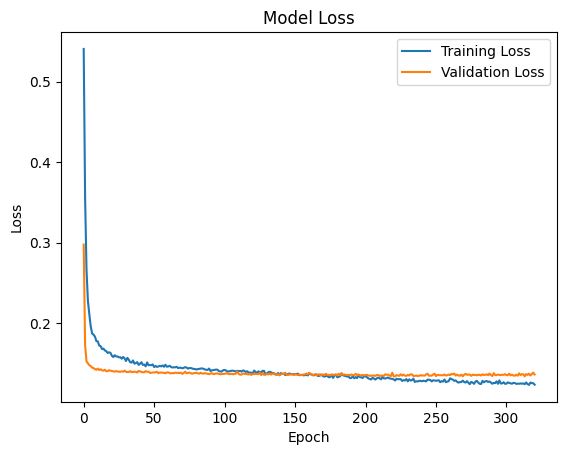

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# genre_mapping 및 titleList 함수 동일하게 유지

# 이미지 데이터와 장르 라벨 가져오는 함수 동일하게 유지

genre_mapping = {
    "드라마": 1 << 43,
    "첩보": 1 << 42,
    "옴니버스": 1 << 41,
    "뮤직": 1 << 40,
    "동성애": 1 << 39,
    "로드무비": 1 << 38,
    "아동": 1 << 37,
    "하이틴(고교)": 1 << 36,
    "전기": 1 << 35,
    "청춘영화": 1 << 34,
    "재난": 1 << 33,
    "문예": 1 << 32,
    "연쇄극": 1 << 31,
    "신파": 1 << 30,
    "활극": 1 << 29,
    "반공/분단": 1 << 28,
    "군사": 1 << 27,
    "계몽": 1 << 26,
    "사회물(경향)": 1 << 25,
    "스포츠": 1 << 24,
    "합작(번안물)": 1 << 23,
    "종교": 1 << 22,
    "무협": 1 << 21,
    "미스터리": 1 << 20,
    "SF": 1 << 19,
    "코메디": 1 << 18,
    "느와르": 1 << 17,
    "액션": 1 << 16,
    "범죄": 1 << 15,
    "어드벤처": 1 << 14,
    "가족": 1 << 13,
    "에로": 1 << 12,
    "멜로/로맨스": 1 << 11,
    '멜로드라마': 1 << 11,
    "공포": 1 << 10,
    "뮤지컬": 1 << 9,
    "시대극/사극": 1 << 8,
    '실험': 1 << 7,
    '스릴러': 1 << 5,
    '서부': 1 << 4,
    '전쟁': 1 << 3,
    '갱스터': 1 << 2,
    '판타지': 1 << 1,
    '해양액션': 1 << 0
}


def titleList(fileName : str):
    
    movieNum = int(fileName.split('_')[1].split('.')[0]) #int(movie)
    titleListGenre = []
    for k, v in genre_mapping.items():
        titleListGenre.append(1 if v & movieNum else 0)
        
    return titleListGenre

def get_image_data_list(folder_path, target_size=(200, 300)):
    # 지원하는 이미지 확장자
    image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')
    
    # 이미지 데이터 목록을 저장할 리스트
    image_data_list = []
    image_genre_list = []
    # 폴더 내의 모든 파일을 순회
    for filename in os.listdir(folder_path):
        # 파일의 경로 생성
        file_path = os.path.join(folder_path, filename)
        
        # 파일이 이미지 확장자 중 하나인지 확인
        if filename.lower().endswith(image_extensions) and os.path.isfile(file_path):
            # 이미지를 열고 지정된 크기로 리사이즈
            # print(file_path, os.path.basename(file_path))
            img = Image.open(file_path)
            # 알파 채널이 있을 경우 제거 (RGBA -> RGB)
            print('filename : ', img.mode)
            if img.mode == 'RGBA' or img.mode == 'CMYK':
                # print("img.mode == 'RGBA'")
                img = img.convert('RGB')
            img_resized = img.resize(target_size)  # 크기 조정
            img_data = np.array(img_resized)  # 이미지를 NumPy 배열로 변환
            image_data_list.append(img_data)
            image_genre_list.append(titleList(os.path.basename(file_path)))

    return (image_data_list, image_genre_list)


# 데이터 준비
folder_path = r'G:\내 드라이브\project_poster\x_train'
folder_test_path = r'G:\내 드라이브\project_poster\x_test'

# 이미지 데이터 및 장르 라벨 가져오기
images_data, images_genre = get_image_data_list(folder_path)
x_train = np.array(images_data)
y_train = np.array(images_genre)

images_data_test, images_genre_test = get_image_data_list(folder_test_path)
x_test = np.array(images_data_test)
y_test = np.array(images_genre_test)

# ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 300, 3))

# ResNet50 모델의 레이어 동결
for layer in base_model.layers:
    layer.trainable = False

# 새로운 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global Average Pooling 사용
    layers.Dense(128, activation='relu'),  # 추가한 Dense 레이어
    layers.Dropout(0.5),  # 과적합 방지를 위한 Dropout
    layers.Dense(len(images_genre[0]), activation='softmax')  # 각 클래스에 대해 확률 출력
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping 콜백 추가 (모니터할 값: val_loss, patience: 10)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# 모델 학습
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
                    epochs=1000,
                    validation_data=test_datagen.flow(x_test, y_test),
                    callbacks=[early_stopping])

# 모델 저장
model_save_path = './genre_resnet.keras'  # 저장할 경로 및 파일 이름
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# 예측
predictions = model.predict(test_datagen.flow(x_test))

# 학습 히스토리 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [2]:
history.history.keys()
history.history['val_accuracy']
predictions
# 예측 결과 해석
threshold = 0.5  # 확률이 0.5 이상이면 해당 장르로 간주
import cv2 as cv
for i, prediction in enumerate(predictions):
    predicted_genres = [genre for idx, genre in enumerate(genre_mapping.keys()) if prediction[idx] >= threshold]
    actual_genres = [genre for idx, genre in enumerate(genre_mapping.keys()) if y_test[i][idx] == 1]
    
    print(f"이미지 {i+1}:")
    # img = cv.cvtColor(x_test[i], cv.COLOR_RGB2BGR)
    # cv.imshow(f"  예측된 장르: {predicted_genres} : {actual_genres}", img)
    # if cv.waitKey(0) == ord('q'):
    #     break
    # cv.destroyWindow(f"  예측된 장르: {predicted_genres} : {actual_genres}")
    # plt.imshow(x_test[i])
    print(f"  예측된 장르: {predicted_genres}")
    print(f"  실제 장르: {actual_genres}")
    print()
# cv.destroyAllWindows()


이미지 1:
  예측된 장르: []
  실제 장르: ['드라마', '뮤직']

이미지 2:
  예측된 장르: []
  실제 장르: ['드라마']

이미지 3:
  예측된 장르: []
  실제 장르: ['드라마']

이미지 4:
  예측된 장르: []
  실제 장르: ['코메디']

이미지 5:
  예측된 장르: []
  실제 장르: ['드라마', '코메디', '범죄']

이미지 6:
  예측된 장르: []
  실제 장르: ['드라마', '멜로/로맨스', '멜로드라마']

이미지 7:
  예측된 장르: []
  실제 장르: ['공포']

이미지 8:
  예측된 장르: []
  실제 장르: ['코메디', '멜로/로맨스', '멜로드라마']

이미지 9:
  예측된 장르: []
  실제 장르: ['어드벤처', '판타지']

이미지 10:
  예측된 장르: ['드라마']
  실제 장르: ['액션', '판타지']

이미지 11:
  예측된 장르: ['드라마']
  실제 장르: ['드라마', '액션']

이미지 12:
  예측된 장르: []
  실제 장르: ['에로']

이미지 13:
  예측된 장르: []
  실제 장르: ['코메디', '멜로/로맨스', '멜로드라마']

이미지 14:
  예측된 장르: ['드라마']
  실제 장르: ['공포', '스릴러']

이미지 15:
  예측된 장르: []
  실제 장르: ['드라마']

이미지 16:
  예측된 장르: []
  실제 장르: ['액션', '멜로/로맨스', '멜로드라마', '스릴러', '판타지']

이미지 17:
  예측된 장르: []
  실제 장르: ['어드벤처']

이미지 18:
  예측된 장르: []
  실제 장르: ['스릴러']

이미지 19:
  예측된 장르: []
  실제 장르: ['공포', '스릴러']

이미지 20:
  예측된 장르: []
  실제 장르: ['공포']

이미지 21:
  예측된 장르: ['드라마']
  실제 장르: ['드라마', '코메디', '가족', '뮤지컬']

이미지 22:
  예측

In [1]:
import easyocr
import cv2

reader = easyocr.Reader(['en'])  # 영어 지원
image = cv2.imread(r'C:\ex\project_poster\shark.jpg')

# OCR 적용
results = reader.readtext(image)
for (bbox, text, prob) in results:
    print(f'Detected text: {text} with probability: {prob:.4f}')


ModuleNotFoundError: No module named 'easyocr'